In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as io
import matplotlib.pyplot as plt
from keras import utils as np_utils
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.stats
import sklearn.metrics
import h5py
from keras.callbacks import EarlyStopping
from keras import models, layers, optimizers, backend, constraints, activations, losses
import complexnn
import TIMBRE.helpers as helpers

In [ ]:
def csp(X1, y, ridge=0):
    """
    Trains a Common Spatial Pattern (CSP) filter bank.

    Parameters:
    X1: Signal for the input class, with dimensions [C x T], where C is the number of channels and T is the number of samples.
    y: Labels for the input data.
    ridge: Regularization term for covariance matrix (default: 0).

    Returns:
    W: Filter matrix (mixing matrix, forward model). Columns are the spatial filters.
    lambda_vals: Eigenvalues of each filter.
    """

    unique_classes = np.unique(y)
    S = np.zeros((X1.shape[1], X1.shape[1], len(unique_classes)), dtype='complex')

    for i, u in enumerate(unique_classes):
        class_data = X1[y == u, :]
        S[:, :, i] = np.cov(class_data, rowvar=False) / np.sum(y == u)
        
    Ss = np.sum(S, axis=2)
    Ss += np.diag(np.diag(Ss)) * ridge

    W = np.zeros(S.shape, dtype='complex')
    lambda_vals = np.zeros((S.shape[0], S.shape[2]),dtype='complex')

    for i in range(S.shape[2]):
        eigvals, eigvecs = np.linalg.eig(Ss,S[:,:,i])#np.linalg.inv(Ss).dot(S[:, :, i])) #did i change this line??
        sorted_indices = np.argsort(eigvals)[::-1]
        lambda_vals[:, i] = eigvals[sorted_indices]
        W[:, :, i] = eigvecs[:, sorted_indices]

    return W, lambda_vals, S

In [ ]:
def csp(X1, y, ridge=0):
    #Trains a CSP filter bank without taking the conjugate in the function to compare accuracy to taking the conjugate inside the function

    unique_classes = np.unique(y)
    S = np.zeros((X1.shape[1], X1.shape[1], len(unique_classes)), dtype='complex')

    for i, u in enumerate(unique_classes):
        class_data = X1[y == u, :]
        S[:, :, i] = np.cov(class_data, rowvar=False) / np.sum(y == u)
        
    Ss = np.sum(S, axis=2)
    Ss += np.diag(np.diag(Ss)) * ridge

    W = np.zeros(S.shape, dtype='complex')
    lambda_vals = np.zeros((S.shape[0], S.shape[2]),dtype='complex')

    for i in range(S.shape[2]):
        eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Ss).dot(S[:, :, i]))
        sorted_indices = np.argsort(eigvals)[::-1]
        lambda_vals[:, i] = eigvals[sorted_indices]
        W[:, :, i] = eigvecs[:, sorted_indices]

    return W, lambda_vals, S

In [ ]:
def filter(matrix, range_low, range_high, btype='bp', fs = 1250/25, order = 3, use_hilbert = True):
    #Bandpass filter for specific broadbands 
    #TIMBRE filter function will not work for bandpass filters!
    nyq = 0.5*fs
    normal_range_low = range_low / nyq
    normal_range_high = range_high / nyq
    b, a = signal.butter(order, [normal_range_low, normal_range_high], btype=btype, analog=False)
    filt_X = signal.filtfilt(b, a, matrix, axis=0)
    return filt_X 

In [ ]:
data = io.loadmat(f'data0{1}.mat') #load drudged data to train models
lapID = data['lapID']
theta_preHilbert = filter(data['lfps'], range_low = 6, range_high = 12, btype= 'bp',order= 2) 
harm_preHilbert = filter(data['lfps'], range_low = 14, range_high = 20, btype= 'bp',order= 2)

In [ ]:
theta_LFPs = signal.hilbert(theta_preHilbert, axis= 0)
harm_LFPs = signal.hilbert(harm_preHilbert, axis= 0)
double_LFPs = np.abs(theta_LFPs)*np.exp(np.angle(theta_LFPs)*2*1j)

In [ ]:
inds_test, inds_train = helpers.test_train(lapID, 1, n_folds=5, which_fold=0)

In [ ]:
_, theta_u, _ = helpers.whiten(theta_LFPs,inds_train)
_, double_u, _ = helpers.whiten(double_LFPs, inds_train)

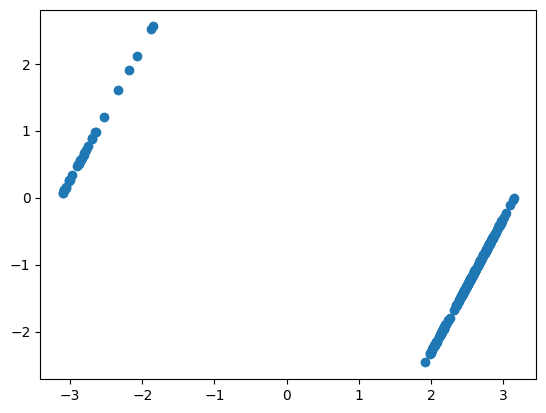

In [ ]:
plt.scatter(np.angle(theta_u[0]), np.angle(double_u[0]))

In [ ]:
#Theta CSP Model
theta_csp, theta_lambdas, theta_S = csp(theta_LFPs[inds_train], lapID[:, 1][inds_train], ridge = 10**-3)
#theta_data = np.abs(np.conj(theta_LFPs)@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1))) #take conjugate here
#theta_CSP_model = sklearn.linear_model.LogisticRegression(penalty=None).fit(theta_data[inds_train],lapID[inds_train,1])

#Harm CSP Model
harm_csp, harm_lambdas, harm_S = csp(harm_LFPs[inds_train], lapID[:, 1][inds_train], ridge = 10**-3)
#harm_data = np.abs(np.conj(harm_LFPs)@harm_csp[:,:1,:].reshape((harm_csp.shape[0], -1))) #take conjugate here
#harm_CSP_model = sklearn.linear_model.LogisticRegression(penalty=None).fit(harm_data[inds_train],lapID[inds_train,1])

#Double CSP Model
double_csp, double_lambdas, double_S = csp(double_LFPs[inds_train], lapID[:, 1][inds_train], ridge = 10**-3)
#double_data = np.abs(np.conj(double_LFPs)@double_csp[:,:1,:].reshape((double_csp.shape[0], -1))) #take conjugate here
#double_CSP_model = sklearn.linear_model.LogisticRegression(penalty=None).fit(double_data[inds_train],lapID[inds_train,1])


TypeError: eig() takes 1 positional argument but 2 were given

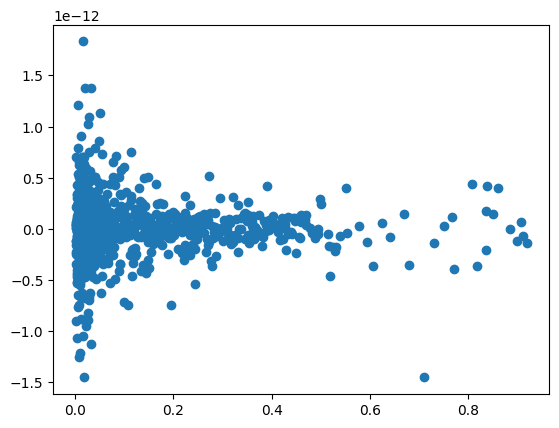

In [ ]:
plt.scatter(np.real(theta_lambdas), np.imag(theta_lambdas))

In [ ]:
theta_csp.shape

(255, 255, 3)

In [ ]:
theta_S_flat = np.reshape(theta_S, (-1))
double_S_flat = np.reshape(double_S, (-1))

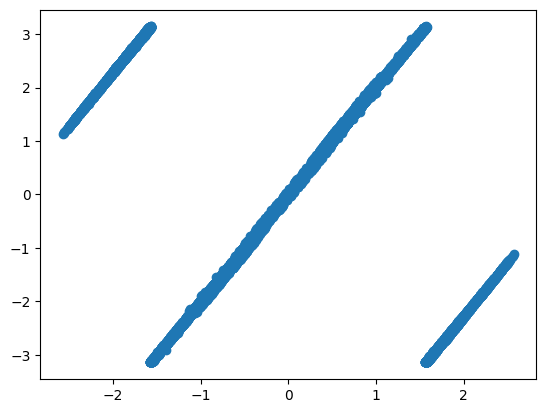

In [ ]:
plt.scatter(np.angle(theta_S_flat), np.angle(double_S_flat))

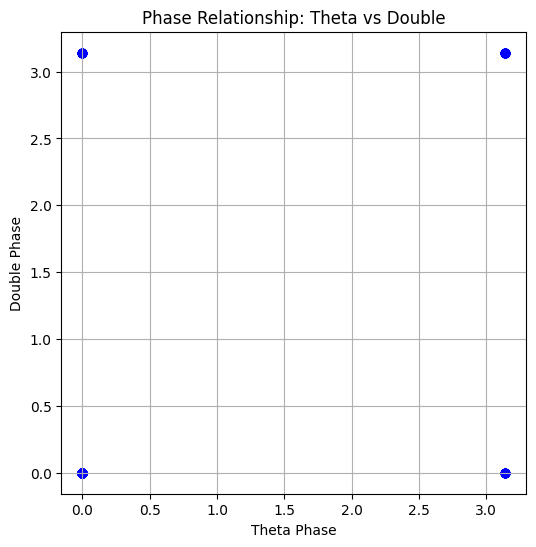

In [ ]:
# Get phase information for theta and double filters
theta_phase = np.angle(W_theta[:, 0])  # First filter for theta
double_phase = np.angle(W_double[:, 0])  # First filter for double

# Plot the phase difference
plt.figure(figsize=(6, 6))
plt.scatter(theta_phase, double_phase, c='blue', alpha=0.7)
plt.xlabel('Theta Phase')
plt.ylabel('Double Phase')
plt.title('Phase Relationship: Theta vs Double')
plt.grid(True)
plt.show()


In [ ]:
first_theta_csp = theta_csp[:,0, 0]  # Extract the first CSP filter
second_theta_csp = theta_csp[:,0, 1]
third_theta_csp = theta_csp[:,0, 2]

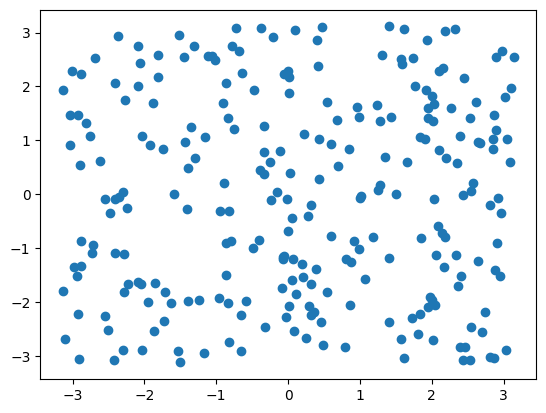

In [ ]:
plt.scatter(np.angle(second_theta_csp), np.angle(third_theta_csp))

In [ ]:

first_harm_csp = harm_csp[:,:, 0]
first_double_csp = double_csp[:,:, 0]

first_theta_phase = np.angle(first_theta_csp) #Extract phase info
harm_phase = np.angle(first_harm_csp)
double_phase = np.angle(first_double_csp)

In [ ]:
print(first_theta_csp.shape)

(255, 255, 3)


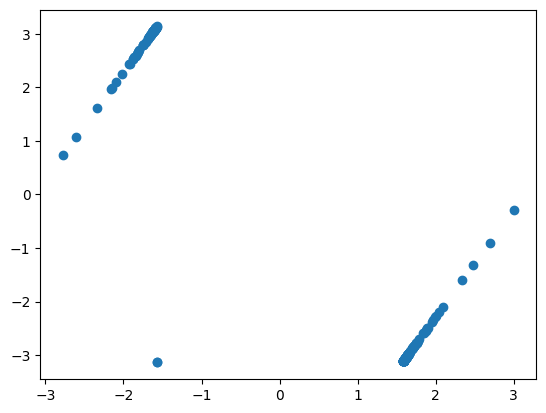

In [ ]:
plt.scatter(np.angle(theta_LFPs[0,:]),np.angle(double_LFPs[0,:]))

ValueError: x and y can be no greater than 2D, but have shapes (255, 255, 3) and (255, 255, 3)

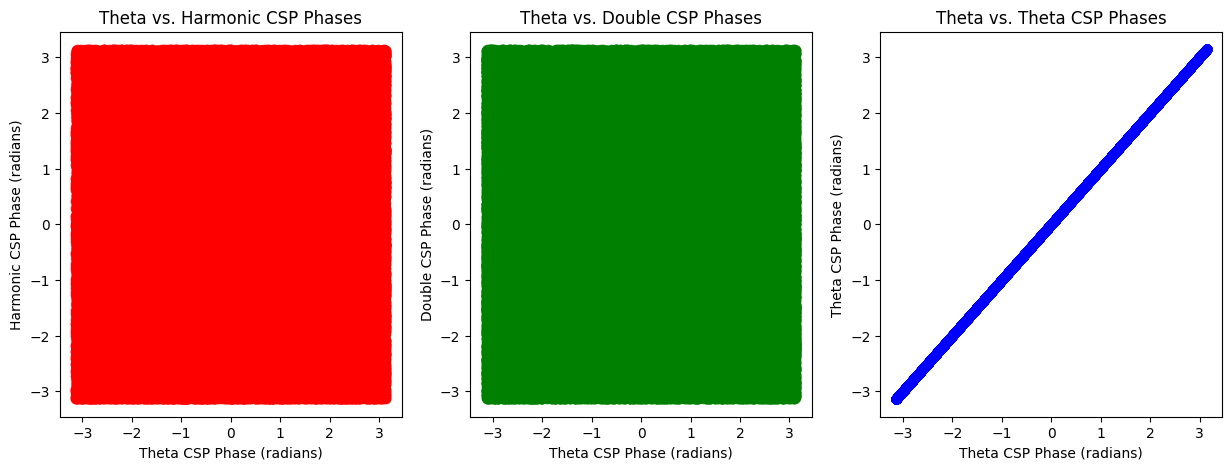

In [ ]:
# Create the figure for the WHOLE first filter
plt.figure(figsize=(15, 5))

# Theta vs. Harmonic CSP Phase
plt.subplot(1, 3, 1)
plt.scatter(theta_phase, harm_phase, color='r', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Harmonic CSP Phase (radians)")
plt.title("Theta vs. Harmonic CSP Phases")

# Theta vs. Double CSP Phase
plt.subplot(1, 3, 2)
plt.scatter(theta_phase, double_phase, color='g', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Double CSP Phase (radians)")
plt.title("Theta vs. Double CSP Phases")

# Theta vs. Theta CSP Phase (should be a diagonal line)
plt.subplot(1, 3, 3)
plt.scatter(theta_phase, theta_phase, color='b', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Theta CSP Phase (radians)")
plt.title("Theta vs. Theta CSP Phases")
plt.plot(theta_phase, theta_phase, color='black', linestyle='--', linewidth=1)  # Diagonal reference line

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Create the figure for the first component of the first filter
plt.figure(figsize=(15, 5))

# Theta vs. Harmonic CSP Phase
plt.subplot(1, 3, 1)
plt.scatter(theta_phase[:,0], theta_phase[:,1], color='r', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Harmonic CSP Phase (radians)")
plt.title("Theta vs. Harmonic CSP Phases")

In [ ]:
theta_csp.shape

(255, 255, 3)

In [ ]:
theta_phase.shape

(255, 255, 3)

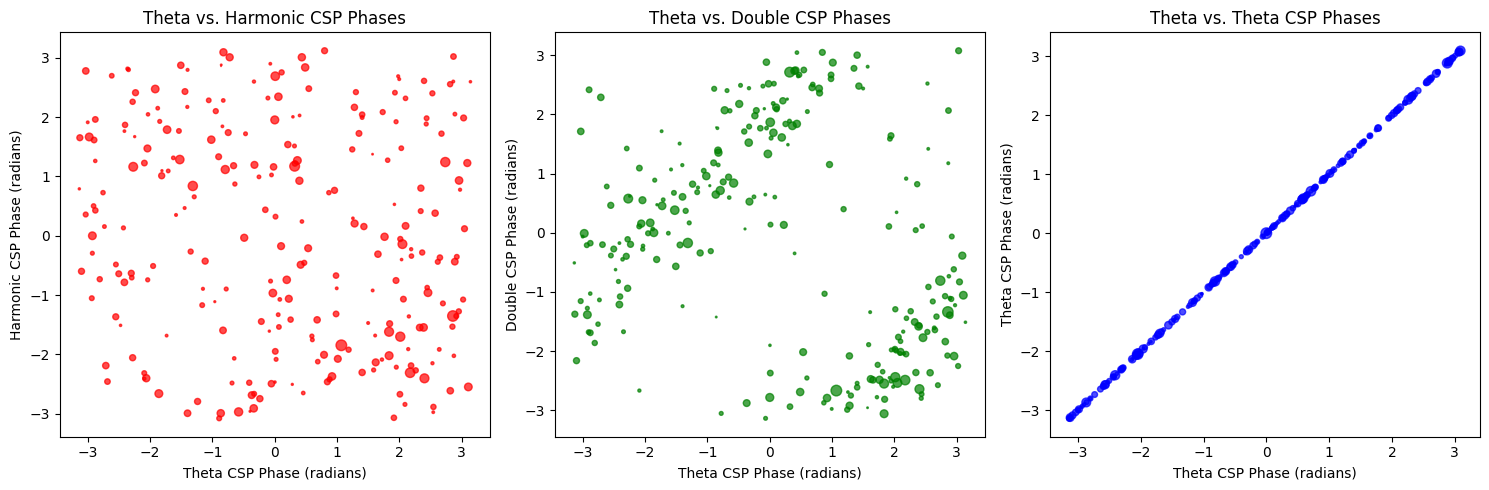

In [ ]:
# Create the figure for the first component of the first filter
plt.figure(figsize=(15, 5))

# Theta vs. Harmonic CSP Phase
plt.subplot(1, 3, 1)
plt.scatter(theta_phase[:,0,1], harm_phase[:,0,1], color='r', alpha=0.7, sizes = (np.abs(theta_csp[:,0,0])*300))
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Harmonic CSP Phase (radians)")
plt.title("Theta vs. Harmonic CSP Phases")

# Theta vs. Double CSP Phase
plt.subplot(1, 3, 2)
plt.scatter(theta_phase[:,0,1], double_phase[:,0,1], color='g', alpha=0.7, sizes = (np.abs(theta_csp[:,0,0])*300))
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Double CSP Phase (radians)")
plt.title("Theta vs. Double CSP Phases")

# Theta vs. Theta CSP Phase (should be a diagonal line)
plt.subplot(1, 3, 3)
plt.scatter(theta_phase[:,0,0], theta_phase[:,0,0], color='b', alpha=0.7, sizes = (np.abs(theta_csp[:,0,0])*300))
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Theta CSP Phase (radians)")
plt.title("Theta vs. Theta CSP Phases")
#plt.plot(theta_phase, theta_phase, color='black', linestyle='--', linewidth=1)  # Diagonal reference line

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

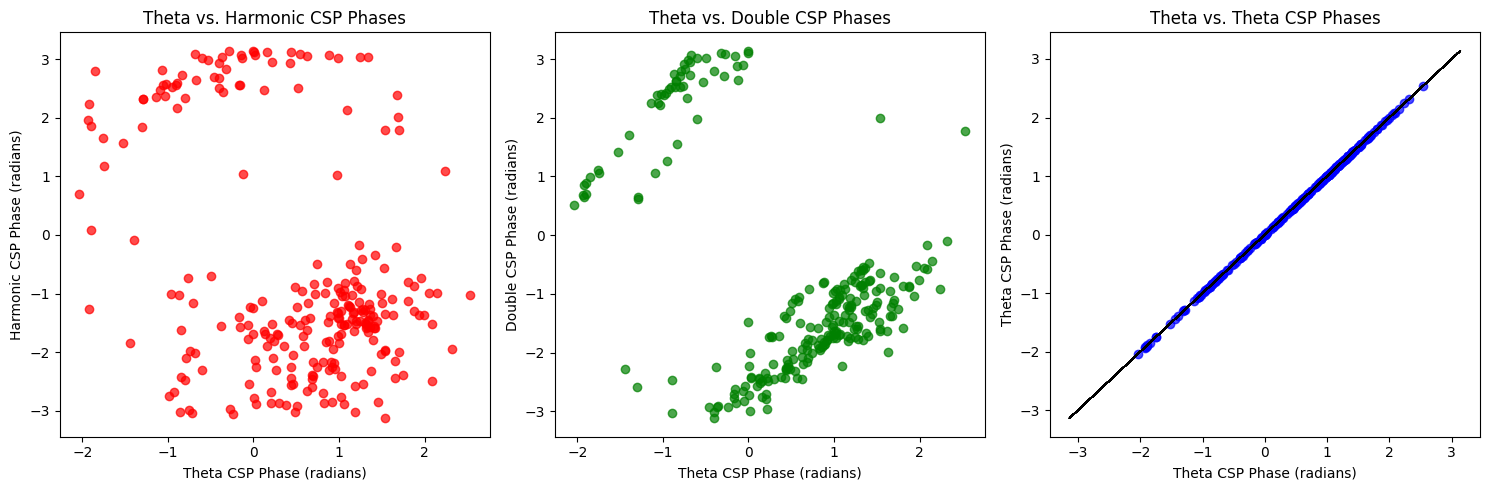

In [ ]:
# Create the figure for the second component of the filter
plt.figure(figsize=(15, 5))

# Theta vs. Harmonic CSP Phase
plt.subplot(1, 3, 1)
plt.scatter(theta_phase[:,1], harm_phase[:,1], color='r', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Harmonic CSP Phase (radians)")
plt.title("Theta vs. Harmonic CSP Phases")

# Theta vs. Double CSP Phase
plt.subplot(1, 3, 2)
plt.scatter(theta_phase[:,1], double_phase[:,1], color='g', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Double CSP Phase (radians)")
plt.title("Theta vs. Double CSP Phases")

# Theta vs. Theta CSP Phase (should be a diagonal line)
plt.subplot(1, 3, 3)
plt.scatter(theta_phase[:,1], theta_phase[:,1], color='b', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Theta CSP Phase (radians)")
plt.title("Theta vs. Theta CSP Phases")
plt.plot(theta_phase, theta_phase, color='black', linestyle='--', linewidth=1, size=)  # Diagonal reference line

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

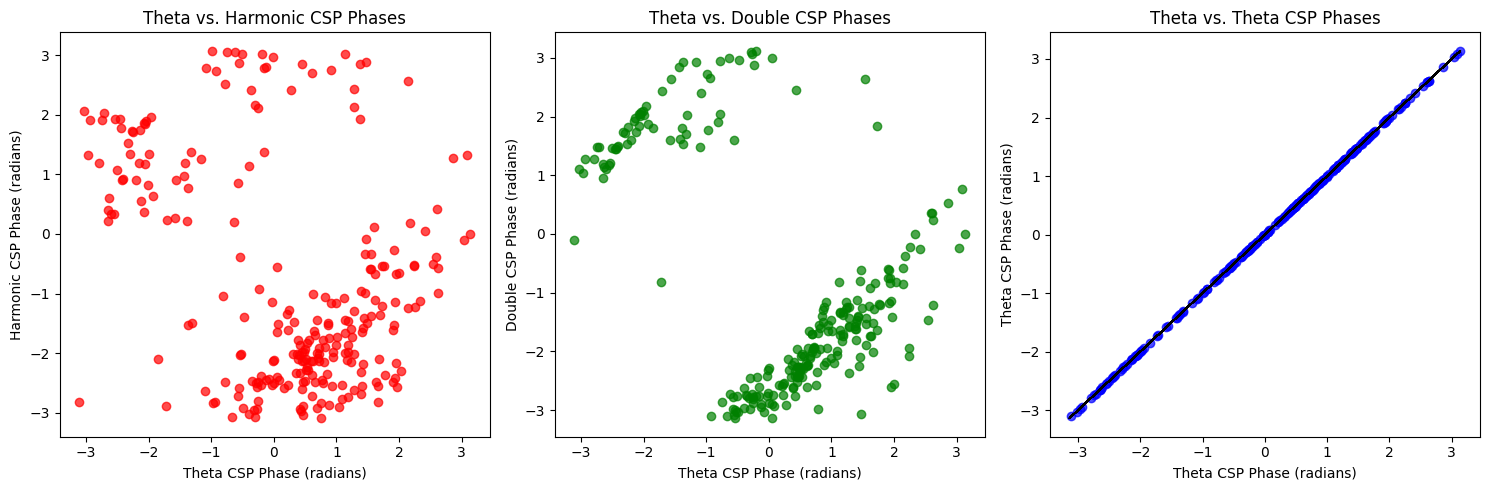

In [ ]:
# Create the figure for the third component of the filter
plt.figure(figsize=(15, 5))

# Theta vs. Harmonic CSP Phase
plt.subplot(1, 3, 1)
plt.scatter(theta_phase[:,2], harm_phase[:,2], color='r', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Harmonic CSP Phase (radians)")
plt.title("Theta vs. Harmonic CSP Phases")

# Theta vs. Double CSP Phase
plt.subplot(1, 3, 2)
plt.scatter(theta_phase[:,2], double_phase[:,2], color='g', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Double CSP Phase (radians)")
plt.title("Theta vs. Double CSP Phases")

# Theta vs. Theta CSP Phase (should be a diagonal line)
plt.subplot(1, 3, 3)
plt.scatter(theta_phase[:,2], theta_phase[:,2], color='b', alpha=0.7)
plt.xlabel("Theta CSP Phase (radians)")
plt.ylabel("Theta CSP Phase (radians)")
plt.title("Theta vs. Theta CSP Phases")
plt.plot(theta_phase, theta_phase, color='black', linestyle='--', linewidth=1)  # Diagonal reference line

# Adjust layout and show the plots
plt.tight_layout()
plt.show()